In [2]:
import os
from PIL import Image
from pymatreader import read_mat

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization)
from tensorflow.keras.optimizers import SGD

# 1. Preprocess
First we need to preprocess data in SVHN dataset. For this example we're gonna crop out every street number from each image and then place them into separate folders. Additionally, we're gonna discard images that are less than 40px in width and less than 80px in height.

In [3]:
def process_images(mat, current_folder, output_folder):
    corr_size = 0
    min_height = 100000
    min_width = 100000
    total_imgs = len(mat['digitStruct']['name'])
    for i, name in enumerate(mat['digitStruct']['name']):
        print(f"Processing image {name}, [{i}/{total_imgs}]")

        imagename = current_folder + os.path.sep + name
        img = Image.open(imagename)
        width, height = img.size
        
        if width >= 40 and height >= 80:
            corr_size += 1
            
            bbox = mat['digitStruct']['bbox'][i]
            num_of_boxes = len(bbox['height']) if isinstance(bbox['height'], list) else 1
            for j in range(num_of_boxes):
                
                label = int(bbox['label'][j]) if isinstance(bbox['label'], list) else int(bbox['label'])
                label = 0 if label == 10 else label # since 10 is actually 0 in SVHN, here we correct label

                # create output folder for each class
                crop_folder = os.path.join(output_folder, f"{label}")
                if not os.path.exists(crop_folder):
                    os.makedirs(crop_folder)
            
                left = int(bbox['left'][j]) if isinstance(bbox['left'], list) else int(bbox['left'])
                upper = int(bbox['top'][j]) if isinstance(bbox['top'], list) else int(bbox['top'])
                width = int(bbox['width'][j]) if isinstance(bbox['width'], list) else int(bbox['width'])
                height = int(bbox['height'][j]) if isinstance(bbox['height'], list) else int(bbox['height'])

                # crop image
                crop = img.crop((left, upper, left + width, upper + height))

                crop_name = crop_folder + os.path.sep + "image_" + str(i) + "_" + str(j) + ".png"
                crop.save(crop_name)
        else:
            min_width = width
            min_height = height


    print('Number of images after filtering:', corr_size)

    print(f"Min size: {min_width}, {min_height}")

In [20]:
train_file = 'data/train/digitStruct.mat'
test_file = 'data/test/digitStruct.mat'

train_mat = read_mat(train_file)

In [8]:
process_images(train_mat, 'data/train', 'processed_data/')

Processing image 1.png, [0/33402]
Processing image 2.png, [1/33402]
Processing image 3.png, [2/33402]
Processing image 4.png, [3/33402]
Processing image 5.png, [4/33402]
Processing image 6.png, [5/33402]
Processing image 7.png, [6/33402]
Processing image 8.png, [7/33402]
Processing image 9.png, [8/33402]
Processing image 10.png, [9/33402]
Processing image 11.png, [10/33402]
Processing image 12.png, [11/33402]
Processing image 13.png, [12/33402]
Processing image 14.png, [13/33402]
Processing image 15.png, [14/33402]
Processing image 16.png, [15/33402]
Processing image 17.png, [16/33402]
Processing image 18.png, [17/33402]
Processing image 19.png, [18/33402]
Processing image 20.png, [19/33402]
Processing image 21.png, [20/33402]
Processing image 22.png, [21/33402]
Processing image 23.png, [22/33402]
Processing image 24.png, [23/33402]
Processing image 25.png, [24/33402]
Processing image 26.png, [25/33402]
Processing image 27.png, [26/33402]
Processing image 28.png, [27/33402]
Processing 

In [9]:
test_mat = read_mat(test_file)

In [10]:
process_images(test_mat, 'data/test', 'processed_data/') # 2546

Processing image 1.png, [0/13068]
Processing image 2.png, [1/13068]
Processing image 3.png, [2/13068]
Processing image 4.png, [3/13068]
Processing image 5.png, [4/13068]
Processing image 6.png, [5/13068]
Processing image 7.png, [6/13068]
Processing image 8.png, [7/13068]
Processing image 9.png, [8/13068]
Processing image 10.png, [9/13068]
Processing image 11.png, [10/13068]
Processing image 12.png, [11/13068]
Processing image 13.png, [12/13068]
Processing image 14.png, [13/13068]
Processing image 15.png, [14/13068]
Processing image 16.png, [15/13068]
Processing image 17.png, [16/13068]
Processing image 18.png, [17/13068]
Processing image 19.png, [18/13068]
Processing image 20.png, [19/13068]
Processing image 21.png, [20/13068]
Processing image 22.png, [21/13068]
Processing image 23.png, [22/13068]
Processing image 24.png, [23/13068]
Processing image 25.png, [24/13068]
Processing image 26.png, [25/13068]
Processing image 27.png, [26/13068]
Processing image 28.png, [27/13068]
Processing 

In [5]:
# Load dataset for training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'processed_data',
    image_size=(64, 64),
    batch_size=64,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    label_mode='categorical' # prepare labels for training
)

Found 22535 files belonging to 10 classes.
Using 18028 files for training.


In [6]:
# Load dataset for training
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'processed_data',
    image_size=(64, 64),
    batch_size=64,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation',
    label_mode='categorical' # prepare labels for training
)

Found 22535 files belonging to 10 classes.
Using 4507 files for validation.


In [7]:
# Check class names
class_num = len(train_ds.class_names)
train_ds.class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Now we're gonna display one example of each class, to ensure that preprocessing was correct

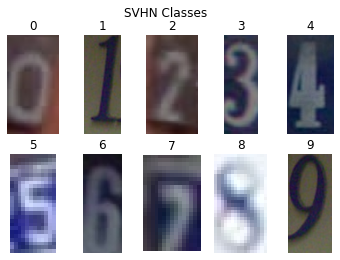

In [8]:
# Display one example for each class
fig = plt.figure()
fig.suptitle('SVHN Classes')
for i in train_ds.class_names:
    imgs = sorted(os.listdir(os.path.join('processed_data', i)))
    ax = plt.subplot(2, 5, int(i)+1)
    img = Image.open(os.path.join('processed_data', i, imgs[0]))
    plt.imshow(img)
    plt.title(i)
    plt.axis('off')

# 2. Train classifier

In [9]:
# One layer according to SVHN paper
def conv_layer(model, filters, strides, kernel_size, name):
    """Conv layer according to paper 'Multi-digit Number Recognition
        from Street View Imagery using Deep Convolutional Neural Networks'
    """

    model.add(Conv2D(filters, (kernel_size, kernel_size), 
           padding='same', name='conv2d_' + name))

    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(strides, strides),
              name='maxpool_2d_' + name))

    model.add(Dropout(0.2))

    return model

model = Sequential()

conv_layer(model, 48, 2, 5, '_48_hidden1')
conv_layer(model, 48, 1, 5, '_48_hidden2')
conv_layer(model, 48, 1, 5, '_48_hidden3')

conv_layer(model, 64, 2, 5, '_64_hidden4')
conv_layer(model, 64, 1, 5, '_64_hidden5')
conv_layer(model, 64, 1, 5, '_64_hidden6')

conv_layer(model, 128, 2, 5, '_128_hidden7')
conv_layer(model, 128, 1, 5, '_128_hidden8')
conv_layer(model, 128, 1, 5, '_128_hidden9')

conv_layer(model, 192, 2, 5, '_192_hidden10')
conv_layer(model, 192, 1, 5, '_192_hidden11')

model.add(Flatten())

model.add(Dense(3072))
model.add(Dense(3072))

x = Input((64,64,3))
y = model(x)

digits = (Dense(10, activation = "softmax"))(y)

classifier = Model(inputs = x, outputs = [digits])

In [10]:
# define optimizer
optimizer = SGD(1e-3)

# compile model with categorical crossentropy
classifier.compile(optimizer=optimizer, loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
# train model
history = classifier.fit(x = train_ds, epochs = 70, validation_data = val_ds, verbose=1)

Epoch 1/70
282/282 [==============================] - 29s 88ms/step - loss: 2.3205 - accuracy: 0.1550 - val_loss: 2.2533 - val_accuracy: 0.1826
Epoch 2/70
282/282 [==============================] - 23s 83ms/step - loss: 2.2882 - accuracy: 0.1684 - val_loss: 2.2521 - val_accuracy: 0.1826
Epoch 3/70
282/282 [==============================] - 24s 83ms/step - loss: 2.2595 - accuracy: 0.1864 - val_loss: 2.2630 - val_accuracy: 0.1826
Epoch 4/70
282/282 [==============================] - 24s 85ms/step - loss: 2.1695 - accuracy: 0.2296 - val_loss: 2.3983 - val_accuracy: 0.1826
Epoch 5/70
282/282 [==============================] - 24s 84ms/step - loss: 2.0463 - accuracy: 0.2801 - val_loss: 2.4883 - val_accuracy: 0.1828
Epoch 6/70
282/282 [==============================] - 24s 84ms/step - loss: 1.8852 - accuracy: 0.3427 - val_loss: 2.2356 - val_accuracy: 0.2035
Epoch 7/70
282/282 [==============================] - 24s 85ms/step - loss: 1.7223 - accuracy: 0.4001 - val_loss: 1.9900 - val_accuracy:

In [12]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

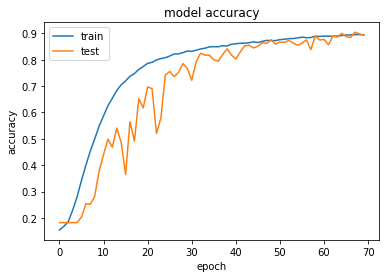

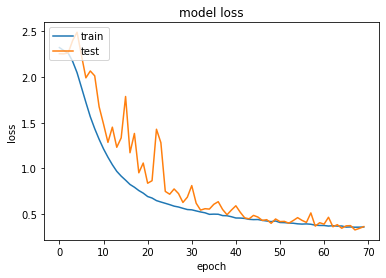

In [13]:
plot_history(history)

# 3. Evaluation

In [ ]:
print("Evaluate on test data")
results = classifier.evaluate(val_ds, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
71/71 [==============================] - 2s 26ms/step - loss: 0.3643 - accuracy: 0.8928
test loss, test acc: [0.3643474876880646, 0.8928333520889282]


In [15]:
# Save model to file
classifier.save('svhn_model.h5')

In [17]:
# load model if needed
classifier = tf.keras.models.load_model('svhn_model.h5')

In [18]:
# get predictions
y_pred = classifier.predict(val_ds, verbose=2)

y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:
   # append true labels
   y_true.append(label_batch)

correct_labels = tf.concat([item for item in y_true], axis = 0)
# calculate confusion matrix
confusion = tf.math.confusion_matrix(
              labels = np.argmax(correct_labels, axis=1),      # get true labels 
              predictions = np.argmax(y_pred, axis=1),  # get predicted labels 
              num_classes=10)

print(confusion)

71/71 - 2s
tf.Tensor(
[[ 26  63  46  40  43  32  30  18  14  22]
 [ 60 177  96 116  89  57  65  71  53  39]
 [ 43 120  72  85  67  48  48  34  49  41]
 [ 40 105  62  60  65  43  49  27  33  41]
 [ 36  89  62  56  32  30  38  23  38  35]
 [ 25  82  57  53  48  32  35  23  36  23]
 [ 34  71  44  42  55  31  23  19  31  27]
 [ 30  67  41  47  32  29  19  18  37  23]
 [ 16  72  43  41  52  28  31  14  16  19]
 [ 25  55  39  33  37  27  29  25  27  16]], shape=(10, 10), dtype=int32)


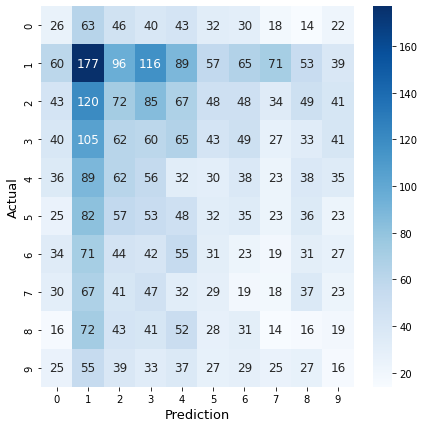

In [19]:
# Visualize confusion matrix
cm = pd.DataFrame(confusion.numpy(), # convert to array
               range(10),range(10))

plt.figure(figsize = (7, 7))
matrix_plot = sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='d', xticklabels=val_ds.class_names,
            yticklabels=val_ds.class_names, cmap='Blues')
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)

fig = matrix_plot.get_figure()
fig.savefig('confusion_matrix.png', format='png', facecolor='white', dpi=150, bbox_inches='tight')
plt.show()